<a href="https://colab.research.google.com/github/Strangeabhi/Ai-Lab/blob/main/Chess_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import requests as rq
url = "https://lichess.org/api/games/user/DrNykterstein?max=100&rated=true&perfType=blitz&analysed=true"
headers = {
    "Accept": "application/x-chess-pgn"
}
response = rq.get(url, headers=headers)
with open("lichess_sample.pgn", "w", encoding="utf-8") as f:
    f.write(response.text)

print("✅ Sample PGN downloaded as 'lichess_sample.pgn'")

✅ Sample PGN downloaded as 'lichess_sample.pgn'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
files.download("lichess_sample.pgn")

In [4]:
!pip install python-chess

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 38.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for chess: filename=chess-1.11.2-py3-none-any.whl size=147775 sha256=1df8937f5a70bfa0f9077a66ad0be15b4f9962425367dff65e6565f4c5903868
  Stored in directory: /root/.cache/pip/wheels/fb/5d/5c/59a62d8a695285e59ec9c1f66add6f8a9ac4152499a2be0113
Successfully built chess


In [5]:
import chess.pgn
import pandas as pd

def extract_features_from_pgn(pgn_file, move_number=20):
    data = []

    with open(pgn_file, encoding="utf-8") as f:
        while True:
            game = chess.pgn.read_game(f)
            if game is None:
                break

            result = game.headers.get("Result", "")
            if result == "1-0" or result == "0-1":
                label = 1
            elif result == "1/2-1/2":
                label = 0
            else:
                continue

            board = game.board()
            for i, move in enumerate(game.mainline_moves(), start=1):
                board.push(move)
                if i == move_number:
                    break
            else:
                continue

            features = {
                "material_balance": mat_diff(board),
                "legal_moves": board.legal_moves.count(),
                "is_white_turn": int(board.turn),
                "label": label
            }
            data.append(features)

    return pd.DataFrame(data)

def mat_diff(board):
    piece_values = {
        chess.PAWN: 1,
        chess.KNIGHT: 3,
        chess.BISHOP: 3,
        chess.ROOK: 5,
        chess.QUEEN: 9
    }

    balance = 0
    for piece_type in piece_values:
        balance += (
            len(board.pieces(piece_type, chess.WHITE)) -
            len(board.pieces(piece_type, chess.BLACK))
        ) * piece_values[piece_type]
    return balance


In [6]:
df = extract_features_from_pgn("lichess_sample.pgn")
print(df.head())

   material_balance  legal_moves  is_white_turn  label
0                 0           30              1      1
1                -3           35              1      1
2                 0           33              1      1
3                 0           43              1      1
4                 0           34              1      1


In [7]:
from sklearn.model_selection import train_test_split

df = df.dropna()

X = df.drop("label", axis=1)
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")


Training samples: 80
Testing samples: 20


Classification Report:

              precision    recall  f1-score   support

           0      0.000     0.000     0.000         1
           1      0.950     1.000     0.974        19

    accuracy                          0.950        20
   macro avg      0.475     0.500     0.487        20
weighted avg      0.903     0.950     0.926        20



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


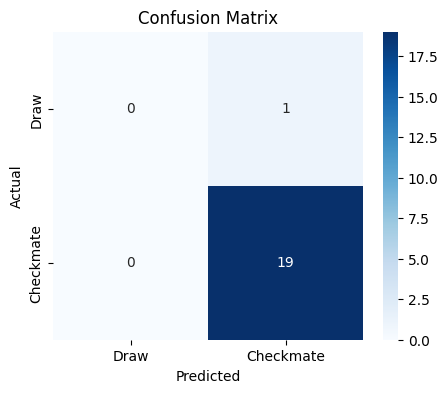

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Classification Report:\n")
print(classification_report(y_test, y_pred, digits=3))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Draw", "Checkmate"],
            yticklabels=["Draw", "Checkmate"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [11]:
import numpy as np

feature_names = X.columns

coefficients = model.coef_[0]

importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefficients,
    "Impact": ["Checkmate +" if c > 0 else "Draw +" for c in coefficients]
})

importance_df["Abs_Coeff"] = np.abs(importance_df["Coefficient"])
importance_df = importance_df.sort_values("Abs_Coeff", ascending=False)

print(importance_df[["Feature", "Coefficient", "Impact"]])


            Feature  Coefficient       Impact
0  material_balance    -0.228211       Draw +
1       legal_moves     0.014993  Checkmate +
2     is_white_turn    -0.000101       Draw +
